## Idea behind converting text to vectors so model can uderstand


In [16]:
from pathlib import Path
import pandas as pd
import os
import pickle
import numpy as np

In [17]:
def build_path(*path_parts):
    base_dir = Path.cwd().parent
    return os.path.join(base_dir, *path_parts)

In [18]:
df = pd.read_csv(build_path('Data', 'IMDB_Dataset.csv'))
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [19]:
import re
from bs4 import BeautifulSoup

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove square brackets and content within
    text = re.sub('\[[^]]*\]', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply all cleaning operations at once
df['review'] = df['review'].apply(clean_text)


In [20]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [21]:
X =df['review']
y = df['sentiment']


In [22]:
X[0:5], y[0:5]

(0    one of the other reviewers has mentioned that ...
 1    a wonderful little production the filming tech...
 2    i thought this was a wonderful way to spend ti...
 3    basically theres a family where a little boy j...
 4    petter matteis love in the time of money is a ...
 Name: review, dtype: object,
 0    positive
 1    positive
 2    positive
 3    negative
 4    positive
 Name: sentiment, dtype: object)

### Encoding the sentiment

In [23]:
from sklearn.preprocessing import LabelEncoder
label_encoder_sentiment = LabelEncoder()
y = label_encoder_sentiment.fit_transform(y)
y[:5]


array([1, 1, 1, 0, 1])

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
import numpy as np

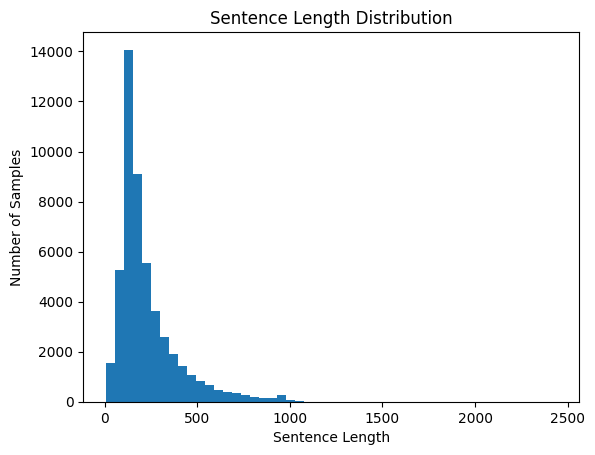

In [25]:
import matplotlib.pyplot as plt

sentence_lengths = [len(text.split()) for text in X]
plt.hist(sentence_lengths, bins=50)
plt.xlabel('Sentence Length')
plt.ylabel('Number of Samples')
plt.title('Sentence Length Distribution')
plt.show()


### observation
- most of the sentence len is less than 500 wors

In [26]:
max_words = 10000  # Size of vocabulary
max_len = 400      # Max words per review

tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [27]:
padded_sequences

array([[  28,    5,    2, ...,    0,    0,    0],
       [   4,  382,  115, ...,    0,    0,    0],
       [  10,  193,   11, ...,    0,    0,    0],
       ...,
       [  10,  225,    4, ...,    0,    0,    0],
       [ 143,  161,    6, ...,    0,    0,    0],
       [  55,   28, 5641, ...,    0,    0,    0]], dtype=int32)

In [28]:
word_index = tokenizer.word_index

In [29]:
import json
## save the one_hot_repr
with open(build_path('Encoder', 'tokenizer.pickle'), 'wb') as handle:
    pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)
    
with open(build_path('Data',"word_index.json"), "w") as f:
    json.dump(word_index, f, indent=2)
    
## save the padded sequences
np.save(build_path('Data', 'X_encoded.npy'), padded_sequences)
np.save(build_path('Data', 'y_encoded.npy'), y)


In [30]:
## train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

## save the train test split
np.save(build_path('Data', 'X_train.npy'), X_train)
np.save(build_path('Data', 'X_test.npy'), X_test)
np.save(build_path('Data', 'y_train.npy'), y_train)
np.save(build_path('Data', 'y_test.npy'), y_test)